<a href="https://colab.research.google.com/github/jana0601/A_Summer-school-LMMS/blob/main/exercise_KRR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

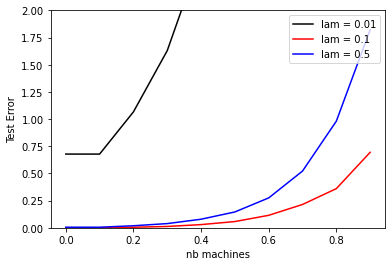

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Aug 21 19:25:24 2021
@author: Nicole
"""

############# Distributed Ridge Regression 
############# simulated Data 
############# regularized KRR 

## for a theoretical description in the context of RKHS's see Sec. 4 of 
## https://www.jmlr.org/papers/volume19/16-569/16-569.pdf


import numpy as np
import matplotlib.pyplot as plt
#from sklearn.model_selection import KFold
import math


## noise variance and standard deviation 

sigma = 0.005**2
sd = np.sqrt(sigma)

## squared empirical L2- norm 

def l2_norm(x):
    """Define norm."""
    return np.sqrt(np.mean(x**2))

### definition regression function 

## low smoothness
def f(x):
    return 0.5*x*(1-x)    

## high smoothness
#def f(x):
#   return (1/(2*np.pi))*np.sin(2*np.pi*x)


### number training and test samples 

n_train=500 
n_test=int(n_train/2)


### define kernel function

def k(x,t):
    return min(x,t)-x*t

## nb local nodes 

alpha = np.array([0,0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
M = n_train**alpha
M = np.floor(M)

np.floor(n_train/M)


### regularization parameter 
## low smoothness 
Lam = np.array([0.01, 0.1, 0.5])

## high smoothness 
#Lam = np.array([0.001, 0.01, 1])

## repitions of the experiment
## we build an average at the end, the larger L, 
## the longer the computation but the smoother the curve!

L = 1

## Error

Error_test = np.zeros((len(M), len(Lam)))


###### begin big loop 

for _ in range(L):
    X_train = np.random.uniform(0, 1, n_train)
    X_test = np.random.uniform(0, 1, n_test) 
    
    Y_train = f(X_train) + np.random.normal(0,sd,n_train)
    Y_test = f(X_test) + np.random.normal(0,sd,n_test)

## kernel matrix training samples 

K = np.zeros((n_train, n_train))

for i in range(n_train):
    for j in range(i):
        K[i,j] = k(X_train[i], X_train[j])
        K[j,i] = K[i,j]
      

KK = np.zeros((n_train, n_test))

for i in range(n_train):
    for j in range(n_test):
        KK[i,j] = k(X_train[i], X_test[j])
        
## begin loop regularization parameter 
## begin loop local machines 

for jj in range(len(Lam)):
    lam = Lam[jj]
    for a in range(len(M)):
        m = int(M[a])
        ## local estimator at test samples
        f_loc = np.zeros(n_test)
        for mm in range(m):
            samples_loc = math.floor(n_train/m)
            ind_machines = np.random.choice(n_train, samples_loc, replace = False)
            #local kernel matrix
            K_loc = K[ind_machines, ind_machines] / samples_loc
            #local labels
            Y_loc = Y_train[ind_machines]
            #local identity matrix
            D = np.diag(np.ones(samples_loc))
            #local coefficients
            coeff_loc = np.linalg.pinv(K_loc+lam*D) @ Y_loc
            coeff_loc = coeff_loc / samples_loc
            #local estimator at test samples 
            f_loc = f_loc + coeff_loc @ KK[ind_machines,:]
            f_ave = f_loc / m
            #test error
            Error_test[a,jj] = Error_test[a,jj] + l2_norm(f_ave - f(X_test))**2
## begin loop regularization parameter 
## begin loop local machines


####### end big loop
        
## averaging 
            
Error = Error_test / L

Efficiency = Error_test[0]/Error_test


### plots 

plt.plot(alpha, Error[:,0], "k-", label=f"lam = {Lam[0]}")
plt.plot(alpha, Error[:,1], "r-", label=f"lam = {Lam[1]}")
plt.plot(alpha, Error[:,2], "b-", label=f"lam = {Lam[2]}")
plt.ylim([0, 2])
plt.xlabel("nb machines")
plt.ylabel("Test Error")
plt.legend(loc="upper right")
plt.show()